In [7]:
from utils_behavior import Sleap_utils
import importlib

from pathlib import Path

from matplotlib import pyplot as plt

import pandas as pd

import numpy as np
import h5py


# Working on one dataset to setup the metrics

In [25]:
importlib.reload(Sleap_utils)

<module 'utils_behavior.Sleap_utils' from '/home/durrieu/utils_behavior/utils_behavior/Sleap_utils.py'>

In [26]:
data_path = Path("/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena4/Right")
video = list(data_path.glob("*.mp4"))[0]
ball = list(data_path.glob("*ball*.h5"))[0]
fly = list(data_path.glob("*fly*.h5"))[0]

balltracks = Sleap_utils.Sleap_Tracks(ball, object_type="ball")
flytracks = Sleap_utils.Sleap_Tracks(fly, object_type="fly")

Experiment = Sleap_utils.CombinedSleapTracks(video, [flytracks, balltracks])

Experiment.dataset

Processing ball 1/2
Processing ball 2/2
Loaded SLEAP tracking file: /mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena4/Right/arena4_right_rotated_tracked_ball.000_arena4_right_rotated.analysis.h5
N° of objects: 2
Nodes: ['centre']
Video FPS: 29.0
Processing fly 1/1
Loaded SLEAP tracking file: /mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena4/Right/arena4_right_rotated_tracked_fly.000_arena4_right_rotated.analysis.h5
N° of objects: 1
Nodes: ['thorax']
Video FPS: 29.0


,frame,time,object,x_thorax,y_thorax,x_centre,y_centre
0,1,0.034483,fly_1,64.588631,516.958679,NaN,NaN
1,2,0.068966,fly_1,64.594406,517.018188,NaN,NaN
2,3,0.103448,fly_1,64.877991,516.980408,NaN,NaN
3,4,0.137931,fly_1,64.642258,516.644409,NaN,NaN
4,5,0.172414,fly_1,64.594658,516.721313,NaN,NaN
...,...,...,...,...,...,...,...
783013,261002,9000.068966,ball_2,NaN,NaN,240.291611,464.425049
783014,261003,9000.103448,ball_2,NaN,NaN,240.281754,464.428009
783015,261004,9000.137931,ball_2,NaN,NaN,240.285873,464.328064
783016,261005,9000.172414,ball_2,NaN,NaN,240.293060,464.430756


## Find when the fly exits the first corridor

This corresponds to having its x position atleast 100 px away from the start

In [27]:
# Get the data for object fly_1
fly1 = Experiment.dataset[Experiment.dataset["object"] == "fly_1"]

# Find the first frame where fly_1 x_thorax is > its initial value + 100 px

fly1[fly1["x_thorax"] > fly1["x_thorax"].iloc[0] + 100].iloc[0]

frame             77816
time        2683.310345
object            fly_1
x_thorax     168.577118
y_thorax     146.832291
x_centre            NaN
y_centre            NaN
Name: 77815, dtype: object

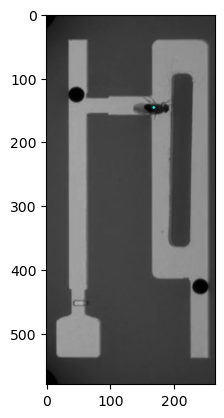

In [28]:
# Display the frame corresponding to the above row

Exit_frame = Experiment.sleap_tracks_list[0].generate_annotated_frame(77816)

plt.imshow(Exit_frame)

## Finding when the second ball is moved

For this one I'm gonna find out when the ball has been displaced 25 px, 50 px, 75 px and 100 px

In [33]:
ball2 = Experiment.dataset[Experiment.dataset["object"] == "ball_2"]

# Initial y_centre value
initial_y_centre = ball2["y_centre"].iloc[0]

# Define the distances to check
distances = [25, 50, 75, 100]

# Find the first row where ball_2 y_centre is greater than 25, 50, 75, and 100 px away from its initial value
for distance in distances:
    filtered_ball2 = ball2[abs(ball2["y_centre"] - initial_y_centre) > distance]
    if not filtered_ball2.empty:
        print(f"Ball reached {distance} px distance:")
        print(filtered_ball2.iloc[0]["time"])
    else:
        print(f"No row found where y_centre is greater than {distance} px away from initial value.")


Ball reached 25 px distance:
5471.620689655172
No row found where y_centre is greater than 50 px away from initial value.
No row found where y_centre is greater than 75 px away from initial value.
No row found where y_centre is greater than 100 px away from initial value.


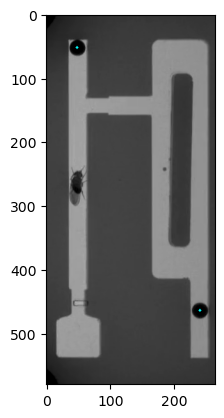

In [30]:
# This fly apparently never moved the ball. Let's check the last frame to see if the ball is still there
last_frame = Experiment.sleap_tracks_list[1].generate_annotated_frame(Experiment.sleap_tracks_list[1].total_frames - 1)

plt.imshow(last_frame)

In [31]:
# CHeck the range of values of the ball_2 y_centre
ball2["y_centre"].min(), ball2["y_centre"].max()

(np.float64(426.4736022949219), np.float64(472.0849304199219))

# Applying to whole dataset

In [14]:
# Get all the directories that contain the videos
data_path = Path("/mnt/upramdya_data/MD/F1_Tracks/Videos/")

# Get all the directories that contain mp4 files
video_paths = list(data_path.glob("**/*.mp4"))

# Initialize a list to store results
results = []

# Define the distances to check for ball movement
distances = [25, 50, 75, 100]


# Process each video folder
for video_path in video_paths:
    video_name = video_path.stem
    fly_files = list(video_path.parent.glob("*fly*.h5"))
    print(f"fly_files: {fly_files}")
    ball_files = list(video_path.parent.glob("*ball*.h5"))
    
    print(f"ball_files: {ball_files}")
    
    if not fly_files or not ball_files:
        print(f"Missing fly or ball file for {video_name}")
        continue
    
    fly = fly_files[0]
    ball = ball_files[0]
    
    # Check if the files are valid HDF5 files
    try:
        with h5py.File(fly, "r") as f:
            pass
        with h5py.File(ball, "r") as b:
            pass
    except OSError as e:
        print(f"Error opening file for {video_name}: {e}")
        # Skip this video
        continue
    
    flytracks = Sleap_utils.Sleap_Tracks(fly, object_type="fly")
    balltracks = Sleap_utils.Sleap_Tracks(ball, object_type="ball")
    
    Experiment = Sleap_utils.CombinedSleapTracks(video_path, [flytracks, balltracks])
    
    # Process fly data
    fly1 = Experiment.dataset[Experiment.dataset["object"] == "fly_1"]
    fly_exit_condition = fly1["x_thorax"] > fly1["x_thorax"].iloc[0] + 100
    if not fly_exit_condition.any():
        print(f"No exit frame found for fly_1 in {video_name}")
        fly_exit_frame = np.nan
        fly_exit_time = np.nan
    else:
        fly_exit_frame = fly1[fly_exit_condition].iloc[0]["frame"]
        fly_exit_time = fly1[fly_exit_condition].iloc[0]["time"]
    
    # Determine which ball object to use and the condition
    if "ball_2" in Experiment.dataset["object"].values:
        ball_object = "ball_2"
        condition = "Pretrained"
    else:
        ball_object = "ball_1"
        condition = "Control"
    
    # Process ball data
    ball_data = Experiment.dataset[Experiment.dataset["object"] == ball_object]
    initial_y_centre = ball_data["y_centre"].iloc[0]
    
    ball_movement_times = {}
    adjusted_ball_movement_times = {}
    for distance in distances:
        filtered_ball_data = ball_data[abs(ball_data["y_centre"] - initial_y_centre) > distance]
        if not filtered_ball_data.empty:
            ball_movement_time = filtered_ball_data.iloc[0]["time"]
            ball_movement_times[distance] = ball_movement_time
            if pd.notna(fly_exit_time):
                adjusted_ball_movement_times[distance] = ball_movement_time - fly_exit_time
            else:
                adjusted_ball_movement_times[distance] = np.nan
        else:
            ball_movement_times[distance] = np.nan
            adjusted_ball_movement_times[distance] = np.nan
    
    # Append the results
    result = {
        "video_name": str(video_path.relative_to(data_path)),
        "condition": condition,
        "fly_exit_time": fly_exit_time,
        **{f"ball_movement_{distance}px": ball_movement_times[distance] for distance in distances},
        **{f"adjusted_ball_movement_{distance}px": adjusted_ball_movement_times[distance] for distance in distances}
    }
    results.append(result)
    
    print(f"Processed {video_name}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to a CSV file
#results_df.to_csv("experiment_results.csv", index=False)

# Display the results
print("Experiment Results:")
results_df.head()

fly_files: [PosixPath('/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena2/Right/arena2_right_rotated_tracked_fly.000_arena2_right_rotated.analysis.h5')]
ball_files: [PosixPath('/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena2/Right/arena2_right_rotated_tracked_ball.000_arena2_right_rotated.analysis.h5')]
Error opening file for arena2_right_rotated: Unable to synchronously open file (file signature not found)
fly_files: [PosixPath('/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena2/Left/arena2_left_tracked_fly.000_arena2_left.analysis.h5')]
ball_files: [PosixPath('/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena2/Left/arena2_left_tracked_ball.000_arena2_left.analysis.h5')]
Processing fly 1/1
Loaded SLEAP tracking file: /mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena2/Left/arena2_left_tracked_fly.000_arena2_left.analysis.h5
N° of objects: 1

,video_name,condition,fly_exit_time,ball_movement_25px,ball_movement_50px,ball_movement_75px,ball_movement_100px,adjusted_ball_movement_25px,adjusted_ball_movement_50px,adjusted_ball_movement_75px,adjusted_ball_movement_100px
0,240924_F1_3mm_ends_Videos_Checked/arena2/Left/...,Pretrained,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240924_F1_3mm_ends_Videos_Checked/arena7/Right...,Pretrained,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,240924_F1_3mm_ends_Videos_Checked/arena7/Left/...,Pretrained,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,240924_F1_3mm_ends_Videos_Checked/arena6/Right...,Pretrained,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,240924_F1_3mm_ends_Videos_Checked/arena6/Left/...,Pretrained,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
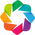

:BoxWhisker   [distance,condition]   (adjusted_time)

In [12]:
import pandas as pd
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

# Assuming results_df is your DataFrame with the necessary columns
# Convert the DataFrame to long format for easier plotting with Holoviews
long_df = pd.melt(results_df, id_vars=['video_name', 'condition', 'fly_exit_time'],
                  value_vars=[f'adjusted_ball_movement_{distance}px' for distance in [25, 50, 75, 100]],
                  var_name='distance', value_name='adjusted_time')

# Extract the distance value from the variable name
long_df['distance'] = long_df['distance'].str.extract('(\d+)').astype(int)

# Create the boxplots
boxplots = hv.BoxWhisker(long_df, ['distance', 'condition'], 'adjusted_time')

# Customize the plot
boxplots.opts(
    opts.BoxWhisker(width=800, height=400, box_fill_color=hv.Cycle('Category20'), 
                    whisker_color='black', show_legend=True, legend_position='top_right',
                    xlabel='Distance (px)', ylabel='Adjusted Time', title='Adjusted Time to Move Ball by Distance')
)

# Display the plot
#hv.save(boxplots, 'boxplots.html')
boxplots

In [13]:
# Count how many videos have control
results_df["condition"].value_counts()

condition
Pretrained    37
Control        1
Name: count, dtype: int64